In [7]:
import dianna
from dianna import visualization
import onnxruntime as ort
import torchvision.transforms as transforms
import torchvision
import torch
import onnxruntime as ort
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import idx2numpy
from PIL import Image
import numpy as np
import cv2

In [8]:
transform = transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [9]:
first_Null = trainset.data[1]

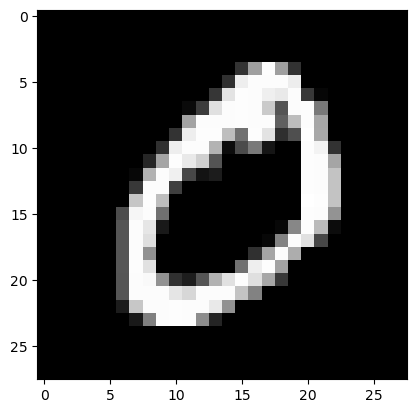

In [10]:
plt.imshow(first_Null, cmap="grey")

In [11]:
model_path = "mnist_model.onnx"

In [12]:
test_input = first_Null.numpy().reshape(1, 28,28).astype(np.float32)

explanation_heatmap_test = dianna.explain_image(model_path, test_input, method="RISE", labels=[0],n_masks=30000)

/Users/parssajashnieh/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/dianna/utils/misc.py:175: UserWarning: The index of the colour channels axis in the input data was automatically determined to be 0. Use the axis_labels to manually specify the index of the channels axis if this is incorrect.
  warnings.warn(
Explaining: 100%|██████████| 100/100 [00:00<00:00, 475.70it/s]


Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 30000/30000 [01:01<00:00, 484.73it/s]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

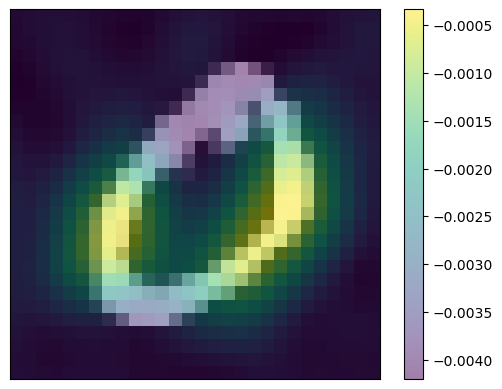

In [13]:
visualization.plot_image(explanation_heatmap_test.reshape(28, 28), original_data=test_input.reshape(28, 28), output_filename="erste_null.jpg")

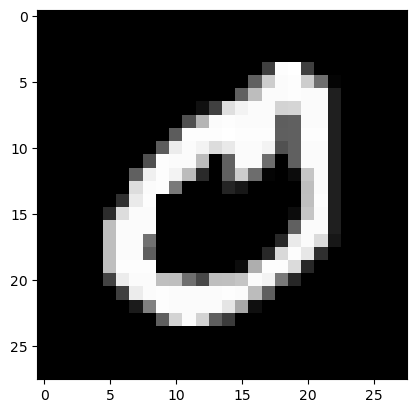

In [14]:
second_null = trainset.data[21]
plt.imshow(second_null, cmap="grey")

/Users/parssajashnieh/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/dianna/utils/misc.py:175: UserWarning: The index of the colour channels axis in the input data was automatically determined to be 0. Use the axis_labels to manually specify the index of the channels axis if this is incorrect.
  warnings.warn(
Explaining: 100%|██████████| 100/100 [00:00<00:00, 489.14it/s]


Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 30000/30000 [01:02<00:00, 482.83it/s]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

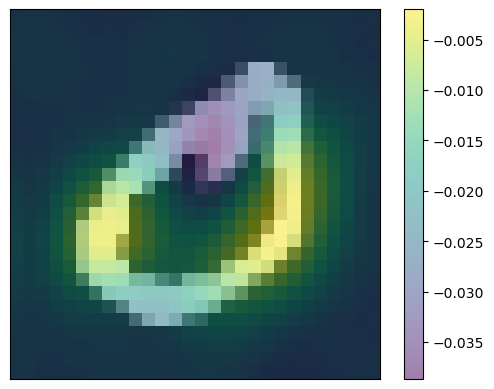

In [15]:
test_input_2 = second_null.numpy().reshape(1, 28,28).astype(np.float32)

explanation_heatmap_test_2 = dianna.explain_image(model_path, test_input_2, method="RISE", labels=[0],n_masks=30000)
visualization.plot_image(explanation_heatmap_test_2.reshape(28, 28), original_data=test_input_2.reshape(28, 28), output_filename="zweite_null.jpg")

In [16]:
test = explanation_heatmap_test + explanation_heatmap_test_2

(<Figure size 640x480 with 2 Axes>, <Axes: >)

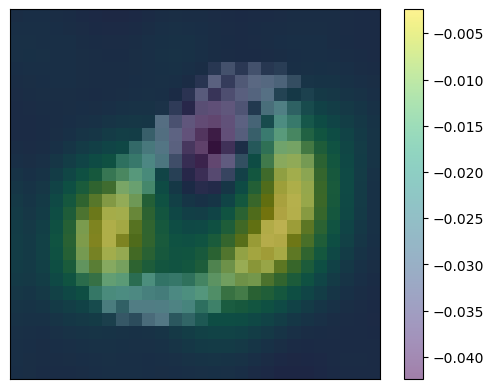

In [17]:
visualization.plot_image(test.reshape(28, 28), ((first_Null + second_null) / 2).numpy().reshape(28, 28),output_filename="erste_und_zweite_durchschnitt")